In [31]:
# %% Ortam Oluşturma
import numpy as np
import random
import matplotlib.pyplot as plt

# Ortam Tahmini 

# class
class RobotKesif:

    #constructor
    def __init__(self, size = 5):
        # size: ortam boyutu
        self.size = size # default olarak 5x5
    
        # state space = observation space = ajanın hareket edebileceği bölgeler,stateler
        self.state_space = size * size # default olarak 25

        # action space = eylem alani
        self.action_space = 4 #sag sol yukari ve asagi

        # baslangic state = baslangic durumu 
        self.start_state = (0,0)

        # hedef kaynak noktalari
        self.goal_states = [(4,4),(1,3)]

        # engeller = cezalar veya kisitlar
        self.obstacles = [(2,2),(3,1)]
        self.lab = np.zeros((size,size))

    # reset function: ortami sifirlamak, ilk haline getirmek
    def reset(self):
        self.robot_position = self.start_state # robotu baslangic pozisynuna ayarlamak
        return self.robot_position # robotu mevcut pozisyouna dondurme

# step function: ortam icerisinde hareket etmek, action sonucunda new state ve reward alinmasi
    def step(self,action):
        x,y = self.robot_position #robotun mevcut koordinatlarini alalim

        if action == 0: #yukari hareket
            x = max(0,x - 1) #  sinirlari kontrol et
        elif action == 1: # asagi hareket
            x = min(self.size - 1,x + 1) # sinirlari kontrol et
        elif action == 2: # sola hareket
            y = max(0, y - 1)
        elif action == 3: # saga hareket
            y = min(self.size - 1, y + 1)

        self.robot_position = (x,y)

        # odul kosullari
        if self.robot_position in self.goal_states:# hedefe ulasildi
            return self.robot_position, 10, True
        elif self.robot_position in self.obstacles:# engelle karsilastiysa
            return self.robot_position, -5, True
        else: # Bos alanda hareket edebiliyorsa
            return self.robot_position, -0.5, False

In [33]:
# %% Q Learning Agent Oluşturma

# class Q LearningAgent class
class QLearningAgent:

    # initizalizer
    def __init__(self,env):
        self.env = env # ortam
        self.start_state = 0
        self.state_space = env.state_space # Ortamın gözlem (durum) alanı boyutu
        self.action_space = env.action_space      # Ortamın eylem alanı boyutu
        self.q_table = np.zeros((self.state_space, self.action_space))  # Q tablosu

        # initialize q table
        self.q_table = np.zeros((env.state_space, env.action_space)) # 25 x 4 matris
        self.alpha = 0.1 # learning rate
        self.gamma = 0.99 # gelecek odullerin indirgeme faktoru
        self.epsilon = 1.0 # kesif rate
        self.epsilon_decay = 0.995 # epsilon degerinin azalmasi icin faktor
        self.min_epsilon = 0.01 # epsilon alt siniri 

    # durum indexi hesaplama
    def get_state_index(self,state):
        return state[0] * self.env.size + state[1] #durumun indeksini hesaplama
        
    # choose action
    def choose_action(self,size):
        if random.uniform(0,1) < self.epsilon: # epsilon greedy stratejisi
            return random.randint(0, self.env.action_space - 1) # kesif icin rastegele eylem sec
        else:
            state_idx = self.get_state_index(state) # mevcut durumun indexini al
            return np.argmax(self.q_table[state_idx]) # en yuksek q degerine sahip eylemi sec
            
    # learning
    def learn(self,state,action,reward,next_state):
        state_idx = self.get_state_index(state) # mevcut durumun indexini al
        next_state_idx = self.get_state_index(next_state) # sonraki durumun indexini alma

        # q degerini guncelleme 
        best_next_action = np.argmax(self.q_table[next_state_idx]) # en iyi eylemi bulma
        td_target = reward + self.gamma * self.q_table[next_state_idx][best_next_action] # hedef q degeri
        td_delta = td_target - self.q_table[state_idx][action] # hata hesabi
        self.q_table[state_idx][action] += self.alpha * td_delta # q tablosunu guncelle

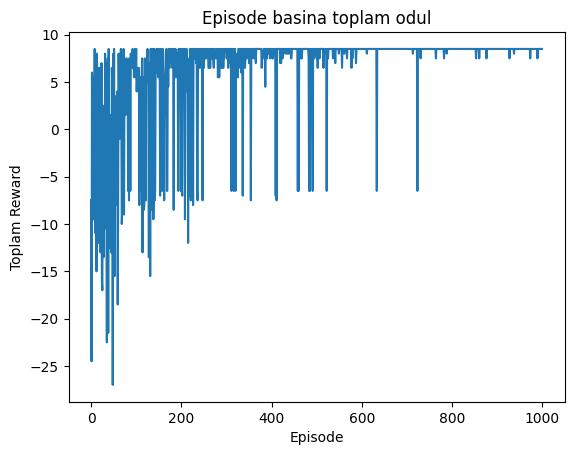

In [35]:
# %% Training and testing

env = RobotKesif() # robot kesif ortami oluustur
agent = QLearningAgent(env) # q-learning agent olustur
episodes = 1000 # episode sayisi tanimla
rewards_per_episode = []# her bir episode icin gerekli olan odullerin saklama listesi

for episode in range(episodes): # her bir episode icin bir dongu baslatma
    state = env.reset() # ortami sifirla (reset)
    total_reward = 0 # toplam odulu sifirla
    done = False # episode tamamlandi durumunu sifirla

    while not done:# episode tamamlandikca while dongusu devam etsin
        action = agent.choose_action(state)# bir eylem secelim
        next_state, reward, done = env.step(action)# ortam icerisinde eylemi uygula yani bir adım at
        agent.learn(state, action, reward, next_state)# learning islemini gerceklestir
        state = next_state# state state guncellemesi yap
        total_reward += reward# toplam odulu guncelle

    agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)# epsilonu guncelle
    rewards_per_episode.append(total_reward)# episode sonunda ki toplam odulu sakla

# sonuclarin gorsellestirilmesi
plt.plot(rewards_per_episode) # her bir bolumda elde edilen odullerin cizdirilmesi
plt.title("Episode basina toplam odul")
plt.xlabel("Episode")
plt.ylabel("Toplam Reward")
plt.show()